In [1]:
# Read the dataset description
from pandas import read_csv

tagged = dict([(p,w) for _,p,w in read_csv('train.csv').to_records()])
submit = [p for _,p,_ in read_csv('submit_example.csv').to_records()]
join   = list(tagged.keys()) + submit
len(tagged),len(submit),len(join),list(tagged.items())[:5],submit[:5]

(4568,
 6846,
 11414,
 [('00101321e69642fda8bf2b625a50016b.jpg', 4),
  ('001a3a430ed746738bb3f55f70756393.jpg', 4),
  ('003471fd6608461ca76f93915dfd4a01.jpg', 4),
  ('0042675be458456da3c8740411272c82.jpg', 1),
  ('00453137e5b04366998380040ebd0bdb.jpg', 4)],
 ['000d9e367ee640caac43b600aac1ff64.jpg',
  '00139ff917a94043bdcd7587b3387df0.jpg',
  '001598ddd5324914a3c6f204528c33d4.jpg',
  '0016d5a8fad64190a7e6506d3e13751d.jpg',
  '001fec23dec047618e0d9560944a385e.gif'])

In [2]:
# Determise the size of each image
from os.path import isfile, getsize
from PIL import Image as pil_image
from tqdm import tqdm_notebook

def expand_path(p):
    if isfile('train\\' + p): return 'train\\' + p
    if isfile('test\\' + p): return 'test\\' + p
    return p
p2size = {}
for p in tqdm_notebook(join):
    try:
        size      = pil_image.open(expand_path(p)).size
    except:
        size = (1,1)
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

D:\Anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
D:\Anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 13631488 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
D:\Anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
D:\Anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
D:\Anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possib

(11414,
 [('00101321e69642fda8bf2b625a50016b.jpg', (471, 341)),
  ('001a3a430ed746738bb3f55f70756393.jpg', (1000, 800)),
  ('003471fd6608461ca76f93915dfd4a01.jpg', (400, 267)),
  ('0042675be458456da3c8740411272c82.jpg', (520, 331)),
  ('00453137e5b04366998380040ebd0bdb.jpg', (1024, 683))])

In [3]:
# Read or generate p2h, a dictionary of image name to image id (picture to hash)
import pickle
import numpy as np
from imagehash import phash
from math import sqrt

# Two phash values are considered duplicate if, for all associated image pairs:
# 1) They have the same mode and size;
# 2) After normalizing the pixel to zero mean and variance 1.0, the mean square error does not exceed 0.1
def match(h1,h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 =  pil_image.open(expand_path(p1))
            i2 =  pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1/sqrt((a1**2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2/sqrt((a2**2).mean())
            a  = ((a1 - a2)**2).mean()
            if a > 0.1: return False
    return True

if isfile('../input/humpback-whale-identification-model-files/p2h.pickle'):
    with open('../input/humpback-whale-identification-model-files/p2h.pickle', 'rb') as f:
        p2h = pickle.load(f)
else:
    # Compute phash for each image in the training and test set.
    p2h = {}
    for p in tqdm_notebook(join):
        try:
            img    = pil_image.open(expand_path(p))
            h      = phash(img)
            p2h[p] = h
        except:
            pass

    # Find all images associated with a given phash value.
    h2ps = {}
    for p,h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)

    # Find all distinct phash values
    hs = list(h2ps.keys())

    # If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
    h2h = {}
    for i,h1 in enumerate(tqdm_notebook(hs)):
        for h2 in hs[:i]:
            if h1-h2 <= 6 and match(h1, h2):
                s1 = str(h1)
                s2 = str(h2)
                if s1 < s2: s1,s2 = s2,s1
                h2h[s1] = s2

    # Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
    for p,h in p2h.items():
        h = str(h)
        if h in h2h: h = h2h[h]
        p2h[p] = h

len(p2h), list(p2h.items())[:5]

D:\Anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
D:\Anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 13631488 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
D:\Anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
D:\Anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
D:\Anaconda3\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possib

(11411,
 [('00101321e69642fda8bf2b625a50016b.jpg', '94b62df22f94615c'),
  ('001a3a430ed746738bb3f55f70756393.jpg', '88b64132f9cc35bb'),
  ('003471fd6608461ca76f93915dfd4a01.jpg', 'de03747c40c6db99'),
  ('0042675be458456da3c8740411272c82.jpg', 'c5a625ed3782139e'),
  ('00453137e5b04366998380040ebd0bdb.jpg', 'c0c82eb71d2f343e')])

In [4]:
# For each image id, determine the list of pictures
h2ps = {}
for p,h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)
# Notice how 25460 images use only 20913 distinct image ids.
len(h2ps),list(h2ps.items())[:5]

(9377,
 [('94b62df22f94615c', ['00101321e69642fda8bf2b625a50016b.jpg']),
  ('88b64132f9cc35bb', ['001a3a430ed746738bb3f55f70756393.jpg']),
  ('de03747c40c6db99',
   ['003471fd6608461ca76f93915dfd4a01.jpg',
    '2d21be5812514468b71b0d3ebac1f745.jpg',
    '68707821086945c3bca5d03f3905cb16.jpg']),
  ('c5a625ed3782139e',
   ['0042675be458456da3c8740411272c82.jpg',
    '5385215c6724464c8cc2c70d15176e8c.jpg']),
  ('c0c82eb71d2f343e', ['00453137e5b04366998380040ebd0bdb.jpg'])])

Images: ['003471fd6608461ca76f93915dfd4a01.jpg', '2d21be5812514468b71b0d3ebac1f745.jpg', '68707821086945c3bca5d03f3905cb16.jpg']


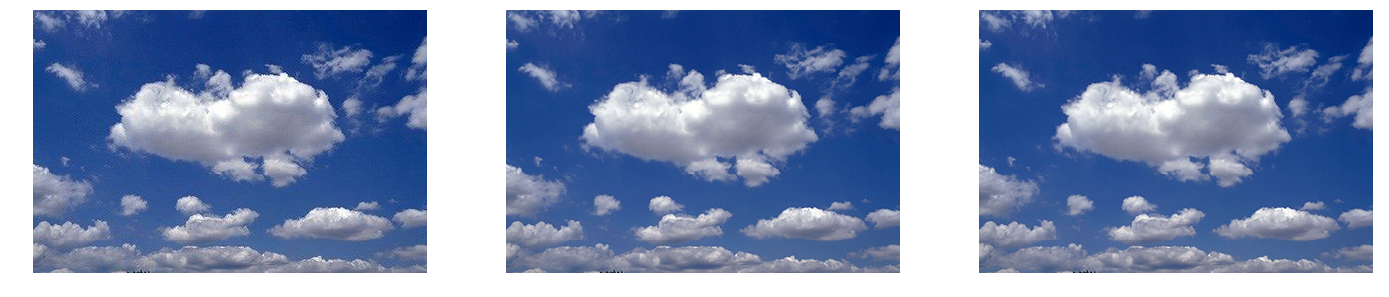

In [5]:
# Show an example of a duplicate image (from training of test set)
import matplotlib.pyplot as plt
%matplotlib inline

def show_whale(imgs, per_row=2):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

for h, ps in h2ps.items():
    if len(ps) > 2:
        print('Images:', ps)
        imgs = [pil_image.open(expand_path(p)) for p in ps]
        show_whale(imgs, per_row=len(ps))
        break

In [6]:
import os
import pandas as pd
from os.path import join, exists, expanduser

data_dir = os.getcwd()
df_train = pd.read_csv(join(data_dir, 'train.csv'))
n = len(df_train)
categories = set(df_train[' type'])
n_class = len(categories)

In [7]:
test = []
for_del = []
for h, ps in h2ps.items():
    if len(ps) > 2:
        in_train = []
        temp_ = []
        for  p in ps:
            temp = False
            for i in range(n):
                if p  == df_train['filename'][i]:
                    temp = True
                    in_train.append(df_train[' type'][i])
                    temp_.append([p, df_train[' type'][i]])
                    print(p, ':', df_train[' type'][i])
            if not temp:
                print(p)
                if in_train:
                    test.append([p, max(in_train)])
        for_del.append(temp_)
        print('\n')

003471fd6608461ca76f93915dfd4a01.jpg : 4
2d21be5812514468b71b0d3ebac1f745.jpg : 4
68707821086945c3bca5d03f3905cb16.jpg


0056d3e0a8814044a6b6f3dd4422d2df.jpg : 4
a45e1749e91a4265a3aa267e743f3d2c.jpg : 4
26d82b177de747ea9975639eda1d900f.jpg
c09dabe5b1504867a95110e189124ea5.jpg


00a550a4365743aab405ab95b84580a1.jpg : 2
00af134f9cce446e8aa0aaa4fb7ea24a.jpg : 2
0b71b4f955904206a3f2dbd437a1eac0.jpg : 2
572dd490be114e269594b6a9b5cffb22.jpg : 2
c0919f92dced4f9f81be7dcbba1123d7.jpg : 2
19f59bffbc134ad5a94a371e2c7f2813.jpg
73d07145f628468283c42af3d9c044ff.jpg
89fd9dd8ddcc4bd099d66c25708aea45.jpg
ad1a4a0a755d486598a49afc0de39db6.jpg
be26bbf51de3429aba51b1bee774bf3e.jpg
d4b7a3f989414ec999aa1f9f4f5bc0a9.jpg
e657429771614ba994fb3566304205c2.jpg
f2fab1421365484dab8c26abfb85cfa7.jpg
f51ede9cbc014ac8a96ab3b52a77a44b.jpg


00e64ff44c27431b8e626daa75a4ba8a.jpg : 5
95a49cec2d0a438db8d1eb3d114d967e.png : 5
f11a0a0ea8654e7e892133c9c061af7d.jpg


01072c33d4594426b2ddb3b0cf806c9f.png : 4
01eea2d6ea6c40809a0

d2e8fe8fc2c847f2a2125bc6bb5b5a62.jpg : 4
027b9e9a949343df8acce5e1a3542982.jpg
3a1483d592b6491992308e0961b2fd4b.jpg
96fada8b1fbe47bbaed7934ab133b9a2.jpg
adc170aa76ed46de8f79457acbb5e4f5.jpg


3095b768dda948c4bdde8e5ad56c2073.jpg : 3
c79f2a21557b4d65a6f5e4392fb510c4.jpg : 3
fb7c45fc477a4a2888913553932a88f6.jpg : 3
e58f8982b12f4f2c93f8a9de64fdfa91.jpg


30b2660e06c3436fb396c71057d2c4ec.jpg : 1
f1f86b7fdfd344c2865355516b57f6ec.jpg : 1
666e1c5bb3a94e738c1ce3cd63f1b2c9.jpg


316acab343b7496089c79e83a24ab29f.jpg : 4
4430b830df6a40bb9b6fba0bba434d0c.jpg : 4
e8fa9792969443c1b307f287bdc602fa.jpg : 4


3197537695d84e44ba02b1de2eebcdee.jpg : 3
965abddc13404c9693179e2197f89d4a.jpg
a2c862e21e2c4f52980d21d082d635da.jpg


320f71b390b64389b9aeb18c90113042.jpg : 4
9f32c048d17f4b8095cf8e17e4b778d0.jpg : 4
fea1fd37a7eb4e1e8a8cbc55d515fd5a.jpg : 4


327b0acb0b5b41e2b2871f3c1c5520dd.jpg : 4
2a07e57759824ebe96a29adacbe8e4a7.jpg
49c6eab403374babb4996762abd820c4.jpg
fcf6c0e17c6d4514bc956977a601f504.jpg


33708

21a849f3d22946a9a4504809558c6536.jpg
56d206480c474ed78156bbdbc75694d7.jpg
acf8474a325e438282bebf59ffa94cdd.jpg
d21af89a72c440f9a27bbf3c0aa83ab7.jpg


73c32b99ee9e4354b8b8077b0719fa67.jpg : 1
a8f3ccd20948463e80a8e33c1722ff49.jpg : 1
b6656449f5c446568304c3a002260bdf.jpg : 1
999e3ae9407a4268845a86946faffeca.jpg
b5257838f6e9419283f97f2ce6d4d9c5.jpg


73ed8c7014df499cba29ea193b44202c.jpg : 4
749d34eee5b74b0086b37d83f36fa0c4.jpg
edaf9dd397d24c0d82f5f8b9005a9669.jpg


74188393e99f4d1ea511b8da3284a7d6.jpg : 4
177c7b8acc9247e183109002e550d556.jpg
2a479a5a3eda4c17a8570f6b20dfccde.jpg
35ed4ad911a24ceb83fd1880f603e15a.jpg


758d8a6560884db5b20b02a05e1dedb8.jpg : 4
7fe76d6f21474ee88577026f82124864.jpg
96a92e57b0b748989594bff051133a75.jpg


7612640e6a034307a94e0161f99164f6.jpg : 4
11873594381641db98e07c0a00620b3b.jpeg
606209beb67e49ccaa9fe2fa4a911bec.jpg
976e1fa33aa446729b2f2b2d38055208.jpg
9f39f56c64424661b1e489d533f1a2cf.jpg
cb0a9b35470945f3803d2dba27085295.jpg
dc1f2970d5764372ae73b2b4c04795c9.jpg

ec0d72e621084435a5c99dd3e7f2da44.jpg : 1
1e4b43cf5bea4f2593c566b113341a18.jpg
608d055f192343d480c19ed99ea3f747.jpg


edc429be22674d2fa254b1dcef015170.jpg : 2
72d1a73bc7d843dc85379cf47e256c81.jpg
f9e30ef60403468cae4f4812d6d3c7de.jpg


edf6b678a6c44a0783ea96f4ff0fd040.jpg : 4
4b8af95995524cd5b223b135947e0c88.jpg
7e374826de9b4320883f3a97bc99f491.jpg


f0aea90f37854c469577dc05fe4e2c35.jpg : 4
6bee2fecd90a41179e01dd365c0c1150.jpg
7c1542e688264f4f863bb8d5b0f00794.jpg


f197549af21141e2983e88884845c575.jpg : 4
90429108575042548abe3977a3ff9c32.jpg
e9640a99e754407db8dbb2b661f1ab82.jpg


f32047051c814464a6c890ae6cf4a846.jpg : 2
0c91213fb7d4454f8f1cc40f0fb166e7.jpg
62b4884379d248549ef3b7dedc20eda9.jpg
63cdba5c4b584a4e9b6d955c8b8b9fb6.jpg
bf2c3c935fb845249dec1be5b55443c1.jpg


f6bad1ae8ddc45aeba1e987eee870eb8.jpg : 4
659ab4125f964647ad48a052d508f18b.jpg
95fedad9b7b84238ba627a1937c98c4f.jpg
aa7269d84c3c4f37afec17e611582860.jpg


f7cd39e70efc485f9828223ec23a0f87.jpg : 4
2d4876eeca5a4d45bb9b617bc7411

In [8]:
# with open('txt.txt', 'w') as f:
#     for line in test:
#         f.write(str(line) + '\n')

In [9]:
te = []
for t in for_del:
    if len(t) < 2:
        continue
    for i in t:
        te.append(i[0])
df_train_del = df_train.drop(df_train.loc[df_train['filename'].isin(te)].index)

In [16]:
to_add = []
for i in for_del:
    if len(i) > 1:
        temppp = []
        for j in i:
            temppp.append(getsize(expand_path(j[0])))
        to_add.append(i[temppp.index(max(temppp))])


In [30]:
df = pd.DataFrame(to_add, columns=['filename', ' type'])
df = df_train_del.append(df)
df.to_csv("train_clean.csv", index=False)   